# **Classification**

## Objectives

*   Fit and evaluate a classification model to predict what Engine Type an airplane design has.


## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/airplane_performance_study.csv")
      .drop(labels=['Model', 'Company', 'THR', 'SHP'], axis=1)  # Should I also drop 'Engine Type'
                    # target variable for regressor, remove from classifier  
                    # drop other variables we will not need for this project
  )

print(df.shape)
df.head(3)

(857, 21)


,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,37.416667,25.250000,10.250000,False,False,0,2050.0,1180.0,241.2,104.0,...,46.0,370.0,13000.0,13000.0,450.0,450.0,900.0,391.970247,1300.0,257.745075
1,36.083333,20.583333,8.750000,False,False,0,1350.0,820.0,100.5,89.0,...,44.0,190.0,12300.0,12300.0,600.0,600.0,720.0,26.247647,800.0,225.324824
2,35.000000,21.416667,8.583333,False,False,0,1300.0,810.0,127.3,90.0,...,37.0,210.0,16000.0,16000.0,650.0,650.0,475.0,363.139711,850.0,585.751317


---

# Step 2: ML Pipeline with all data

## ML pipeline for Data Cleaning and Feature Engineering

Set variables=None to avoid error in first code cell under Handle Target Imbalance!

Below you should include the categorical features to the ordinal_variables and the numerical continous to the yeo_johnson_variables (do not include the target variable, Engine_Type, you deal with that separately!)

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer

def PipelineDataCleaningAndFeatureEngineering():
    # Specify variables for Ordinal Encoder and Power Transformer
    ordinal_variables = ['TP_mods', 'Multi_Engine']
    
    # Specify the numerical variables for Yeo-Johnson transformation
    yeo_johnson_variables = ['Wing_Span', 'Length', 'Height', 'AUW', 'MEW',
                             'FW', 'Vmax', 'Vcruise', 'Vstall', 'Range', 
                             'Hmax', 'Hmax (One)', 'ROC', 'ROC (One)',
                             'Vlo', 'Slo', 'Vl', 'Sl']

    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(variables=ordinal_variables)),
        
        ("YeoJohnsonTransformer", PowerTransformer(method='yeo-johnson')),
        
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
    ])

    return pipeline_base

pipeline = PipelineDataCleaningAndFeatureEngineering()


## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


## Split Train and Test Set

Looking at the shapes shows that 80% is taken for a train and the rest (20%) is for test. 

In [8]:
df['Multi_Engine'] = df['Multi_Engine'].astype(object)
df['TP_mods'] = df['TP_mods'].astype(object)
df['Engine_Type'] = df['Engine_Type'].astype(object)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Engine_Type'], axis=1),
    df['Engine_Type'],
    test_size=0.2,
    random_state=0,
)
print(df.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# df = pd.DataFrame(y_train.shape)
# print(df.dtypes)


(857, 21)
(685, 20) (685,) (172, 20) (172,)


685 + 172 = 857 perfect result from the split of the data set (75% train and 25% test)!


In [ ]:
print(df)

In [ ]:
print(X_train)

In [ ]:
print(y_train)

In [ ]:
print(X_test)

In [ ]:
print(y_test)

## Handle Target Imbalance

We already see upfront on the Kaggle site for this data that the 'Multi Engine' categorical data is in need of rebalancing


<img src="/workspace/data-driven-design/images_notebook/cat_data_distr_kaggle.png" alt="Information on three categorical features showing the degree of target imbalance" height="200" />


In [10]:
X_train.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,AUW,MEW,FW,Vmax,Vcruise,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
196,64.333333,68.416667,20.666667,True,False,48300.0,26985.0,20000.0,546.94,533.6,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
645,37.166667,31.166667,10.250000,True,False,5200.0,3229.0,964.8,220.00,197.0,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
122,37.666667,25.583333,9.500000,True,False,4880.0,2960.0,750.4,200.00,191.0,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


In [11]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train,y_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(685, 3) (685,) (172, 3) (172,)


In [12]:
X_train.head(3)

,x4,x14,x15
0,0.274505,0.992116,-0.166453
1,0.274505,0.236785,-1.523499
2,0.274505,0.340854,-1.163546


Check Train Set Target distribution

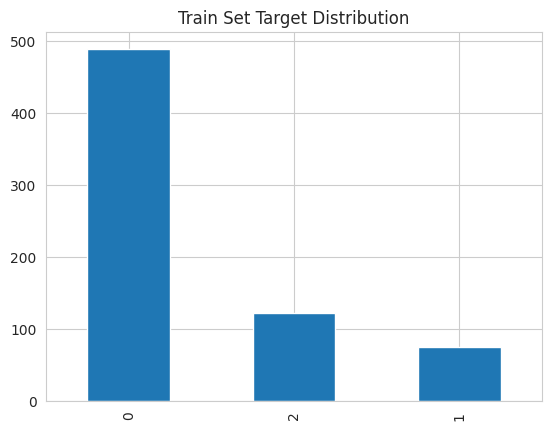

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

Following five codecells takes care of error message with smote. The t_train (target) is an object but with Yes and No however making it to a int64 with 1 and 0 solves it!

In [14]:
print(y_train)

196    2
645    0
122    0
851    0
167    0
      ..
835    1
192    2
629    1
559    0
684    0
Name: Engine_Type, Length: 685, dtype: object


In [15]:
print("Unique labels in y_train:", np.unique(y_train))
print("Data type of y_train:", y_train.dtype)

Unique labels in y_train: [0 1 2]
Data type of y_train: object


In [16]:
y_train = y_train.astype(int)

In [17]:
print("Unique labels in y_train after conversion:", np.unique(y_train))
print("Data type of y_train after conversion:", y_train.dtype)

Unique labels in y_train after conversion: [0 1 2]
Data type of y_train after conversion: int64


In [18]:
print(y_train)

196    2
645    0
122    0
851    0
167    0
      ..
835    1
192    2
629    1
559    0
684    0
Name: Engine_Type, Length: 685, dtype: int64


In [19]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1098, 3) (1098,) (172, 3) (172,)


Check Train Set Target distribution after resampling

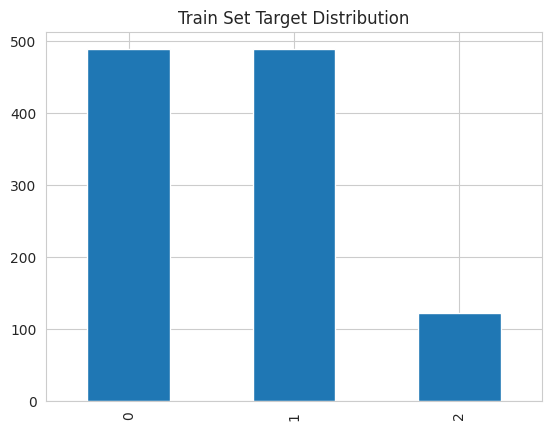

In [20]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

In [21]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}


Quick GridSearch CV - Binary Classifier

In [22]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-


Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-


Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-


Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-

Check results

In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,NaN,NaN,NaN,NaN
1,XGBClassifier,NaN,NaN,NaN,NaN
2,DecisionTreeClassifier,NaN,NaN,NaN,NaN
3,RandomForestClassifier,NaN,NaN,NaN,NaN
4,GradientBoostingClassifier,NaN,NaN,NaN,NaN
5,ExtraTreesClassifier,NaN,NaN,NaN,NaN
6,AdaBoostClassifier,NaN,NaN,NaN,NaN


### Do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [24]:
models_search = {
    "XGBClassifier":XGBClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBClassifier":{
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV - Binary Classifier

In [25]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-

Check results

In [26]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth
0,XGBClassifier,NaN,NaN,NaN,NaN,0.1,3
1,XGBClassifier,NaN,NaN,NaN,NaN,0.1,10
2,XGBClassifier,NaN,NaN,NaN,NaN,0.1,None
3,XGBClassifier,NaN,NaN,NaN,NaN,0.01,3
4,XGBClassifier,NaN,NaN,NaN,NaN,0.01,10
5,XGBClassifier,NaN,NaN,NaN,NaN,0.01,None
6,XGBClassifier,NaN,NaN,NaN,NaN,0.001,3
7,XGBClassifier,NaN,NaN,NaN,NaN,0.001,10
8,XGBClassifier,NaN,NaN,NaN,NaN,0.001,None


Get best model name programmatically

In [27]:
best_model = grid_search_summary.iloc[0,0]
best_model

'XGBClassifier'

Parameters for best model

In [28]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 3}

Define the best clf pipeline

In [29]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importanc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## Assess feature importance

In [30]:
X_train.head(3)

,x4,x14,x15
0,0.274505,0.992116,-0.166453
1,0.274505,0.236785,-1.523499
2,0.274505,0.340854,-1.163546


* With the current model, we can assess with `.features_importances_`

* These are the 2 most important features in descending order. The model was trained on them: 
['x14', 'x4']


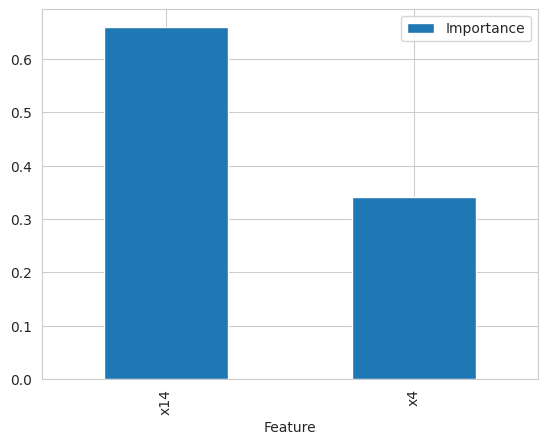

In [31]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


TEST-DELETE: Trying to access which columns the 19th and 15th columns are but since the X_train are only 3 columns I get an out of bounds!

In [32]:
# Access the column names using iloc
nineteenth_column_name = X_train.columns[18]  # 18 corresponds to the 19th column
fifteenth_column_name = X_train.columns[14]    # 14 corresponds to the 15th column

print(f"The name of the 19th column is: {nineteenth_column_name}")
print(f"The name of the 15th column is: {fifteenth_column_name}")


IndexError: index 18 is out of bounds for axis 0 with size 3

TEST-DELETE: Note that the 'The name of the 3th column is: x15' does not make sense!

In [33]:
# Access the column names using iloc
third_column_name = X_train.columns[2]

print(f"The name of the 3th column is: {third_column_name}")

The name of the 3th column is: x15


## Evaluate Pipeline on Train and Test Sets

In [34]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Evaluation: We cross check with metrics defined at ML business case
* 80% Recall for Churn, on train and test set
* 80% Precision for no Churn on train and test set. 

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Single Engine', 'Multi Engine'] 
                )

In [ ]:
print("Unique labels in y_test:", np.unique(y_test))

In [ ]:
print("Unique labels in y_test:", np.unique(y_test))


# Step 3: Refit pipeline with best features

## Refit ML Pipeline and Resampling

In theory, a pipeline fitted **using only the most important features** should give the same result as the one fitted with **all variables and feature selection**

* However, in this project we have a step for feature augmentation, which is to balance the target Train Set using SMOTE().


## Rewrite ML pipeline for Data Cleaning and Feature Engineering

In [35]:
best_features

['x14', 'x4']

New Pipeline for DataCleaning And FeatureEngineering

In [38]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['InternetService', 'Contract'])),


        # we don't need SmartCorrelatedSelection
    ])

    return pipeline_base


## Rewrite ML Pipeline for Modelling

Function for Pipeline optmisation

In [39]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base


## Split Train Test Set, considering only with best features

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Engine_Type'], axis=1),
    df['Engine_Type'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(685, 20) (685,) (172, 20) (172,)


We filter only the most important variables

In [42]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(685, 0) (685,) (172, 0) (172,)


""
196
645
122


## Handle Target Imbalance

In [43]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ValueError: 0 feature(s) (shape=(685, 0)) while a minimum of 1 is required.

Check Train Set Target distribution

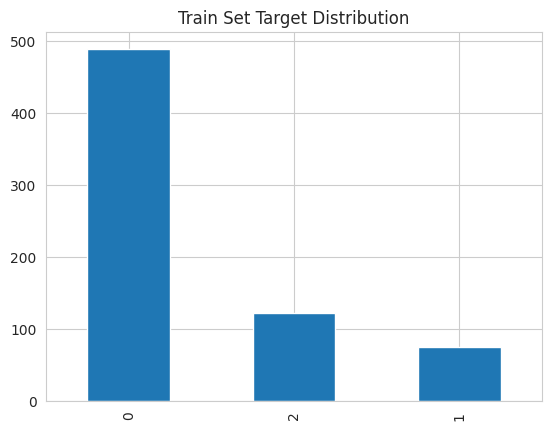

In [44]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Use SMOTE to balance Train Set target

In [46]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Check Train Set Target distribution after SMOTE

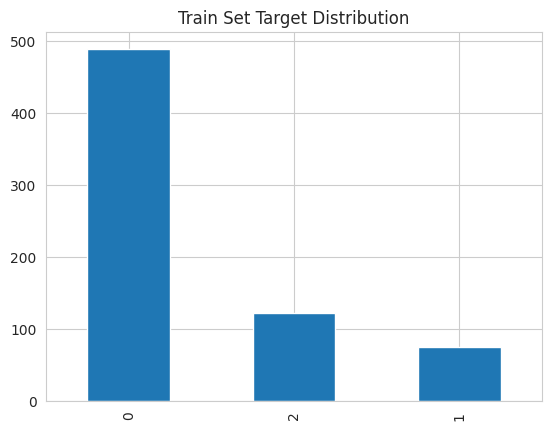

In [47]:
y_train.value_counts().plot(kind='bar',title='Train Set Target Distribution')
plt.show()

## Grid Search CV: Sklearn

Using the most suitable model from the last section and its best hyperparameter configuration.

We are using the same model from  the last GridCV search

In [48]:
models_search   # XGBClassifier

{'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=0, ...)}

And the best parameters from the last GridCV search 

In [49]:
best_parameters

{'model__learning_rate': 0.1, 'model__max_depth': 3}

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [50]:
params_search = {'XGBClassifier':  {
    'model__learning_rate': [0.01],   # the value should be in []
    'model__max_depth': [3]},  # the value should be in []
}
params_search


{'XGBClassifier': {'model__learning_rate': [0.01], 'model__max_depth': [3]}}

GridSearch CV

In [51]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)



Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/workspace/.pip-modules/lib/python3.8/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 839, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 875, in partial_fit
    X = self._validate_data(
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py", line 605, in _validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/validation.py", line 795, in check_array
    dtype_orig = np.result_type(*dtypes_orig)
  File "<__array_function__ internals>", line 200, in result_type
ValueError: at least one array or dtype is required


Check results

In [52]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

ValueError: No objects to concatenate

Define the best clf pipeline

In [53]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         device=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature_types=None,
                                                         gamma=None,
                                                         grow_policy=None,
                                                         importanc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## Assess feature importance

In [54]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


ValueError: All arrays must be of the same length

## Evaluate Pipeline on Train and Test Sets

Evaluation: We cross-check with metrics defined in the ML business case.
* 80% Recall for Churn, on train and test set.
* 80% Precision for no Churn on train and test set. 

In [55]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Churn', 'Churn'] 
                )

#### Train Set #### 



/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: at least one array or dtype is required

# Step 4: Push files to Repo

We will generate the following files
* Train set
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_churn/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Train Set

* note that the variables **are transformed already** in X_train and the shape is 8266 - after SMOTE was applied.

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set

* note that the variables are transformed already in X_test

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## ML Pipelines: Data Cleaning and Feat Eng pipeline and Modelling Pipeline

We will save 2 pipelines: 
* Both should be used in conjunction to predict Live Data.
* To predict on Train Set, Test Set we use only pipeline_clf, since the data is already processed.



Pipeline responsible for Data Cleaning and Feature Engineering.


In [ ]:
pipeline_data_cleaning_feat_eng

In [ ]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

* Pipeline responsible for Feature Scaling, and Model

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

## Feature Importance plot

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job, you should clear outputs, then run git commands to push files to the repo. Next, move on to Predict Tenure notebook

---